In [ ]:
!pip install opencv-python
!pip install torchmetrics
!pip install torchsummary

import torch
import random
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from PIL import Image
from torchmetrics import Accuracy, Precision, Recall, F1Score
import pytorch_lightning as pl
from torchsummary import summary
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import nn
from torchmetrics import Accuracy, Precision, Recall, F1Score
import torchmetrics

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

clear_output()

/kaggle/input/crop-diseases-classification/Data/label_num_to_disease_map.json
/kaggle/input/crop-diseases-classification/Data/train.csv


In [ ]:
# Set random seed for PyTorch
torch.manual_seed(42)
# Set random seed for CUDA (GPU computations)
torch.cuda.manual_seed(42)
# Set random seed for NumPy operations on CPU
np.random.seed(42)
# Set random seed for Python's random module
random.seed(42)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [ ]:
image_path = "/kaggle/input/crop-diseases-classification/Data/train_images"
image_list = os.listdir(image_path)
df = pd.read_csv("/kaggle/input/crop-diseases-classification/Data/train.csv")

df.shape, len(image_list) 
# 17938 image varken train.csv 21397 veri içeriyor image idlere göre filtreleyeceğiz
# Filtreleme işlemi
df = df[df["image_id"].isin(image_list)]
df.reset_index(drop=True, inplace=True)
df.shape
#Json dosyasındaki label numaralarına göre isimleri içeri aktaralım
with open("/kaggle/input/crop-diseases-classification/Data/label_num_to_disease_map.json", "r") as file:
    label_name = json.load(file)
label_name

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

In [21]:
data_transform = transforms.Compose([
    transforms.Resize(size=(227, 227)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomResizedCrop(227),
    transforms.RandomRotation(degrees=15),

    #transforms.RandomGrayscale(p=0.1),
    #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

test_transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])


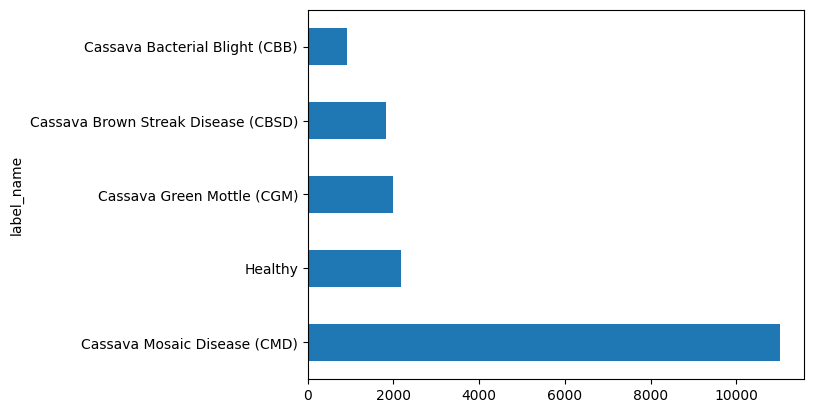

In [6]:
df['label_name'] = df['label'].astype(str).map(label_name)
df
df['label_name'].value_counts().plot(kind='barh')
plt.show()

In [ ]:
# Sample alalım label numaralarına göre isimlerini aldığımız image'ları görüntüleyelim
sample = df.sample(6)
plt.figure(figsize=(10, 10))
j = 0
for i, row in sample.iterrows():
    path = image_path + "/" + row['image_id']  
    plt.subplot(3,2,j+1)
    j += 1
    img = Image.open(path)
    plt.imshow(img)
    plt.axis('off')
    img_shape = np.asarray(img)
    plt.title(label_name[str(row['label'])] + f"\nshape: {img_shape.shape}")
j = 0
plt.show()

In [ ]:

plt.figure(figsize=(5, 10))
j = 0
for i, row in sample.iterrows():
    path = image_path + "/"+ row['image_id']
    plt.subplot(6, 2, j+1)
    j += 1
    img = Image.open(path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Original \nshape: {img_shape.shape}")
    plt.subplot(6, 2, j+1)
    j += 1
    img_transformed = data_transform(img)
    plt.imshow(img_transformed.permute(1, 2, 0))  # Tensor formatını RGB formatına dönüştürme
    plt.axis('off')
    plt.title(f'Transformed \n{img_transformed.shape}')
plt.tight_layout()
plt.show()

In [9]:
import shutil

def create_folders(df, train_ratio=0.9):
    
    for label_name in df['label_name'].unique():
        train_folder_path = os.path.join('/kaggle/working/train', label_name)
        test_folder_path = os.path.join('/kaggle/working/test', label_name)
        os.makedirs(train_folder_path, exist_ok=True)
        os.makedirs(test_folder_path, exist_ok=True)

        
    
        label_df = df[df['label_name'] == label_name]
        train_size = int(len(label_df) * train_ratio)
        train_df = label_df.sample(n=train_size)
        test_df = label_df.drop(train_df.index)

        
        copy_images(train_df, train_folder_path)
        copy_images(test_df, test_folder_path)


def copy_images(df, destination_path):
    for index, row in df.iterrows():
        source_path = os.path.join('/kaggle/input/crop-diseases-classification/Data/train_images', row['image_id'])
        destination_file_path = os.path.join(destination_path, row['image_id'])
        shutil.copy(source_path, destination_file_path)


create_folders(df)

import os


def count_files_in_folder(folder_path):
    return len(os.listdir(folder_path))


train_folder = '/kaggle/working/train'
test_folder = '/kaggle/working/test'

for label_name in os.listdir(train_folder):
    train_label_path = os.path.join(train_folder, label_name)
    test_label_path = os.path.join(test_folder, label_name)

    train_count = count_files_in_folder(train_label_path)
    test_count = count_files_in_folder(test_label_path)

    print(f"Label '{label_name}' için eğitim veri sayısı: {train_count}")
    print(f"Label '{label_name}' için test veri sayısı: {test_count}")

image_path = "/kaggle/working/"
train_dir = "/kaggle/working/train"
test_dir = "/kaggle/working/test"
target_directory = train_dir
print(f"Target directory: {target_directory}")

class_names_found = sorted([entry.name for entry in os.scandir(os.path.join(image_path, "train"))])
print(f"Class names found: {class_names_found}")

from typing import List, Dict, Tuple


def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

Label 'Cassava Brown Streak Disease (CBSD)' için eğitim veri sayısı: 1647
Label 'Cassava Brown Streak Disease (CBSD)' için test veri sayısı: 184
Label 'Cassava Green Mottle (CGM)' için eğitim veri sayısı: 1793
Label 'Cassava Green Mottle (CGM)' için test veri sayısı: 200
Label 'Healthy' için eğitim veri sayısı: 1949
Label 'Healthy' için test veri sayısı: 217
Label 'Cassava Bacterial Blight (CBB)' için eğitim veri sayısı: 828
Label 'Cassava Bacterial Blight (CBB)' için test veri sayısı: 93
Label 'Cassava Mosaic Disease (CMD)' için eğitim veri sayısı: 9924
Label 'Cassava Mosaic Disease (CMD)' için test veri sayısı: 1103
Target directory: /kaggle/working/train
Class names found: ['Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)', 'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)', 'Healthy']


In [22]:
from torch.utils.data import Dataset
from pathlib import Path
import pathlib
import random


class ImageFolderCustom(Dataset):

    def __init__(self, targ_dir: str, transform=None, num_samples_to_remove=0) -> None:

        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) 
     
        self.transform = transform
        
        self.classes, self.class_to_idx = find_classes(targ_dir)

        self.samples_to_remove = []
        if num_samples_to_remove > 0:
            label_3_indices = [idx for idx, path in enumerate(self.paths) if path.parent.name == 'Cassava Mosaic Disease (CMD)']
            self.samples_to_remove = random.sample(label_3_indices, num_samples_to_remove)
            self.paths = [path for idx, path in enumerate(self.paths) if idx not in self.samples_to_remove]

    
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)

    
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)

    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        
        if self.transform:
            return self.transform(img), class_idx 
        else:
            return img, class_idx # return data, label (X, y)

In [23]:

train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=data_transform,
                                      num_samples_to_remove = 0)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transform,
                                    num_samples_to_remove= 0)
train_data_custom, test_data_custom, len(train_data_custom), len(test_data_custom)


(<__main__.ImageFolderCustom at 0x797764227d30>,
 16141,
 1797)

In [24]:
def cutout(img, n_holes=1, length=16):
    h, w = img.size(2), img.size(3)  # Get the height and width dimensions

    mask = torch.ones_like(img)  # Create a mask tensor with the same shape as the image tensor

    for _ in range(n_holes):
        y = np.random.randint(h)
        x = np.random.randint(w)

        y1 = np.clip(y - length // 2, 0, h)
        y2 = np.clip(y + length // 2, 0, h)
        x1 = np.clip(x - length // 2, 0, w)
        x2 = np.clip(x + length // 2, 0, w)

        mask[:, :, y1:y2, x1:x2] = 0.0  # Update the mask tensor for each batch item

    return img * mask  # Apply the mask to the image tensor

def cutmix(img1, img2, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    batch_size, _, h, w = img1.size()
    bbx1, bby1, bbx2, bby2 = rand_bbox((h, w), lam)
    img1[:, :, bbx1:bbx2, bby1:bby2] = img2[:, :, bbx1:bbx2, bby1:bby2]
    return img1, lam

def rand_bbox(size, lam):
    W, H = size
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2


In [25]:

TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 16
NUM_WORKERS = 2
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom, 
                                     batch_size=TRAIN_BATCH_SIZE, 
                                     num_workers=NUM_WORKERS, 
                                     shuffle=True) 

test_dataloader_custom = DataLoader(dataset=test_data_custom, 
                                    batch_size=TEST_BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False) 

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x797754c9a170>,
 <torch.utils.data.dataloader.DataLoader at 0x797754c986a0>)

In [32]:
def train_step(model, dataloader, loss_fn, optimizer, device):
    model.train()

    loss_metric = nn.CrossEntropyLoss()
    accuracy_metric = Accuracy(num_classes=5, task='multiclass').to(device)
    precision_metric = Precision(num_classes=5, average='macro', task='multiclass').to(device)
    recall_metric = Recall(num_classes=5, average='macro', task='multiclass').to(device)
    f1_metric = F1Score(num_classes=5, average='macro', task='multiclass').to(device)

    total_loss = 0
    with torch.enable_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Randomly choose between cutout and cutmix for each batch
            if random.random() < 0.5:
                X, lam = cutmix(X, X[torch.randperm(X.size(0))])
            #X = cutout(X)  # Apply cutout
            #else:
                 

            y_pred = model(X)
            loss = loss_metric(y_pred, y)
            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            accuracy_metric.update(y_pred_class, y)
            precision_metric.update(y_pred_class, y)
            recall_metric.update(y_pred_class, y)
            f1_metric.update(y_pred_class, y)

    total_loss /= len(dataloader)
    accuracy = accuracy_metric.compute()
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    f1 = f1_metric.compute()

    return total_loss, accuracy, precision, recall, f1

In [33]:


def test_step(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              device: torch.device):
    model.eval()

    loss_metric = loss_fn
    accuracy_metric = Accuracy(num_classes=5,task='multiclass').to(device)
    precision_metric = Precision(num_classes=5, average='macro',task='multiclass').to(device)
    recall_metric = Recall(num_classes=5, average='macro',task='multiclass').to(device)
    f1_metric = F1Score(num_classes=5, average='macro',task='multiclass').to(device)

    total_loss = 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)
            loss = loss_metric(test_pred_logits, y)
            total_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            accuracy_metric.update(test_pred_labels, y)
            precision_metric.update(test_pred_labels, y)
            recall_metric.update(test_pred_labels, y)
            f1_metric.update(test_pred_labels, y)

    total_loss /= len(dataloader)
    accuracy = accuracy_metric.compute()
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    f1 = f1_metric.compute()

    return total_loss, accuracy, precision, recall, f1

In [34]:
def train(model: nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          scheduler: torch.optim.lr_scheduler,
          loss_fn: nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")):

    model.to(device)

    loss_metric = loss_fn
    accuracy_metric = Accuracy(num_classes=5, task='multiclass').to(device)
    precision_metric = Precision(num_classes=5, average='macro', task='multiclass').to(device)
    recall_metric = Recall(num_classes=5, average='macro', task='multiclass').to(device)
    f1_metric = F1Score(num_classes=5, average='macro', task='multiclass').to(device)

    results = {"train_loss": [], "train_acc": [], "train_precision": [], "train_recall": [], "train_f1": [],
               "test_loss": [], "test_acc": [], "test_precision": [], "test_recall": [], "test_f1": []}

    for epoch in tqdm(range(epochs), desc="Training"):
        train_loss, train_acc, train_precision, train_recall, train_f1 = train_step(model=model,
                                                                                    dataloader=train_dataloader,
                                                                                    loss_fn=loss_metric,
                                                                                    optimizer=optimizer,
                                                                                    device=device)
        test_loss, test_acc, test_precision, test_recall, test_f1 = test_step(model=model,
                                                                              dataloader=test_dataloader,
                                                                              loss_fn=loss_metric,
                                                                              device=device)

        scheduler.step(test_loss)  # Pass the validation loss to scheduler.step()

        print(f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"train_precision: {train_precision:.4f} | "
              f"train_recall: {train_recall:.4f} | "
              f"train_f1: {train_f1:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f} | "
              f"test_precision: {test_precision:.4f} | "
              f"test_recall: {test_recall:.4f} | "
              f"test_f1: {test_f1:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["train_precision"].append(train_precision)
        results["train_recall"].append(train_recall)
        results["train_f1"].append(train_f1)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        results["test_precision"].append(test_precision)
        results["test_recall"].append(test_recall)
        results["test_f1"].append(test_f1)

    return results


In [35]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class BottleneckBlock(nn.Module):
    expansion = 4
    
    def __init__(self, in_channels, intermediate_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, intermediate_channels, kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(intermediate_channels, intermediate_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(intermediate_channels, intermediate_channels * self.expansion, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)

        self.downsample = None
        if stride != 1 or in_channels != intermediate_channels * self.expansion:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, intermediate_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(intermediate_channels * self.expansion)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, intermediate_channels, num_blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, intermediate_channels, stride))
        self.in_channels = intermediate_channels * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, intermediate_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# ResNet-18
def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

# ResNet-34
def ResNet34(num_classes=10):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)

# ResNet-50
def ResNet50(num_classes=10):
    return ResNet(BottleneckBlock, [3, 4, 6, 3], num_classes)

# ResNet-101
def ResNet101(num_classes=10):
    return ResNet(BottleneckBlock, [3, 4, 23, 3], num_classes)

# ResNet-152
def ResNet152(num_classes=10):
    return ResNet(BottleneckBlock, [3, 8, 36, 3], num_classes)


model_18 = ResNet18(num_classes=5)
model_34 = ResNet34(num_classes=5)
model_50 = ResNet50(num_classes=5)
model_101 = ResNet101(num_classes=5)
model_152 = ResNet152(num_classes=5)




In [36]:
# VGGNet Modeli
model = model_152.to(device)

# EfficientNet-B4 modeli
#model = timm.create_model('efficientnet_b4', pretrained=True)
#model.classifier = nn.Linear(in_features=model.classifier.in_features, out_features=5)


In [37]:
import timm
import torch.optim as optim
from tqdm import tqdm
from torch import nn
from torchmetrics import Accuracy, Precision, Recall, F1Score
from torch.nn.parallel import DataParallel


model.to(device)
if torch.cuda.device_count() > 1:
    model = DataParallel(model)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

results = train(model=model,
                train_dataloader=train_dataloader_custom,
                test_dataloader=test_dataloader_custom,
                optimizer=optimizer,
                scheduler=scheduler,
                loss_fn=nn.CrossEntropyLoss(),
                epochs=40,
                device=device)


Training:   2%|▎         | 1/40 [04:14<2:45:30, 254.62s/it]

Epoch: 1 | train_loss: 1.1863 | train_acc: 0.6093 | train_precision: 0.2537 | train_recall: 0.2090 | train_f1: 0.1754 | test_loss: 1.1703 | test_acc: 0.5971 | test_precision: 0.3113 | test_recall: 0.2384 | test_f1: 0.2296


Training:   5%|▌         | 2/40 [08:29<2:41:20, 254.75s/it]

Epoch: 2 | train_loss: 1.1024 | train_acc: 0.6155 | train_precision: 0.3032 | train_recall: 0.2302 | train_f1: 0.2116 | test_loss: 1.1420 | test_acc: 0.6021 | test_precision: 0.2451 | test_recall: 0.2159 | test_f1: 0.1905


Training:   8%|▊         | 3/40 [12:44<2:37:06, 254.77s/it]

Epoch: 3 | train_loss: 1.0723 | train_acc: 0.6251 | train_precision: 0.3603 | train_recall: 0.2526 | train_f1: 0.2430 | test_loss: 1.0852 | test_acc: 0.6060 | test_precision: 0.3137 | test_recall: 0.2451 | test_f1: 0.2265


Training:  10%|█         | 4/40 [16:58<2:32:38, 254.39s/it]

Epoch: 4 | train_loss: 1.0468 | train_acc: 0.6269 | train_precision: 0.3388 | train_recall: 0.2636 | train_f1: 0.2597 | test_loss: 1.0604 | test_acc: 0.6210 | test_precision: 0.1849 | test_recall: 0.2416 | test_f1: 0.2080


Training:  12%|█▎        | 5/40 [21:12<2:28:21, 254.33s/it]

Epoch: 5 | train_loss: 1.0400 | train_acc: 0.6278 | train_precision: 0.3503 | train_recall: 0.2657 | train_f1: 0.2627 | test_loss: 1.0847 | test_acc: 0.6205 | test_precision: 0.3688 | test_recall: 0.3181 | test_f1: 0.3098


Training:  15%|█▌        | 6/40 [25:26<2:24:10, 254.42s/it]

Epoch: 6 | train_loss: 1.0199 | train_acc: 0.6345 | train_precision: 0.3828 | train_recall: 0.2792 | train_f1: 0.2800 | test_loss: 1.1041 | test_acc: 0.5949 | test_precision: 0.5560 | test_recall: 0.3653 | test_f1: 0.3335


Training:  18%|█▊        | 7/40 [29:41<2:19:55, 254.42s/it]

Epoch: 7 | train_loss: 0.9907 | train_acc: 0.6420 | train_precision: 0.3953 | train_recall: 0.3017 | train_f1: 0.3058 | test_loss: 0.9601 | test_acc: 0.6511 | test_precision: 0.5912 | test_recall: 0.3422 | test_f1: 0.3422


Training:  20%|██        | 8/40 [33:55<2:15:37, 254.30s/it]

Epoch: 8 | train_loss: 0.9750 | train_acc: 0.6457 | train_precision: 0.4167 | train_recall: 0.3102 | train_f1: 0.3171 | test_loss: 0.9530 | test_acc: 0.6544 | test_precision: 0.4754 | test_recall: 0.3142 | test_f1: 0.3296


Training:  22%|██▎       | 9/40 [38:09<2:11:17, 254.13s/it]

Epoch: 9 | train_loss: 0.9736 | train_acc: 0.6431 | train_precision: 0.4238 | train_recall: 0.3091 | train_f1: 0.3186 | test_loss: 0.9454 | test_acc: 0.6600 | test_precision: 0.4529 | test_recall: 0.3847 | test_f1: 0.3729


Training:  25%|██▌       | 10/40 [42:23<2:07:05, 254.18s/it]

Epoch: 10 | train_loss: 0.9502 | train_acc: 0.6520 | train_precision: 0.4325 | train_recall: 0.3287 | train_f1: 0.3417 | test_loss: 1.1265 | test_acc: 0.5815 | test_precision: 0.4154 | test_recall: 0.4396 | test_f1: 0.3872


Training:  28%|██▊       | 11/40 [46:38<2:02:57, 254.39s/it]

Epoch: 11 | train_loss: 0.9502 | train_acc: 0.6473 | train_precision: 0.4253 | train_recall: 0.3254 | train_f1: 0.3363 | test_loss: 1.0359 | test_acc: 0.6166 | test_precision: 0.4333 | test_recall: 0.2916 | test_f1: 0.2923


Training:  30%|███       | 12/40 [50:52<1:58:41, 254.35s/it]

Epoch: 12 | train_loss: 0.9389 | train_acc: 0.6565 | train_precision: 0.4577 | train_recall: 0.3431 | train_f1: 0.3647 | test_loss: 0.9805 | test_acc: 0.6455 | test_precision: 0.4699 | test_recall: 0.4620 | test_f1: 0.4541


Training:  32%|███▎      | 13/40 [55:05<1:54:18, 254.01s/it]

Epoch: 13 | train_loss: 0.9020 | train_acc: 0.6686 | train_precision: 0.4796 | train_recall: 0.3746 | train_f1: 0.3960 | test_loss: 1.0453 | test_acc: 0.6349 | test_precision: 0.5096 | test_recall: 0.3862 | test_f1: 0.3979


Training:  35%|███▌      | 14/40 [59:19<1:49:59, 253.81s/it]

Epoch: 14 | train_loss: 0.9113 | train_acc: 0.6679 | train_precision: 0.4817 | train_recall: 0.3685 | train_f1: 0.3925 | test_loss: 0.8693 | test_acc: 0.6761 | test_precision: 0.5117 | test_recall: 0.3638 | test_f1: 0.3803


Training:  38%|███▊      | 15/40 [1:03:32<1:45:41, 253.67s/it]

Epoch: 15 | train_loss: 0.8858 | train_acc: 0.6726 | train_precision: 0.4791 | train_recall: 0.3812 | train_f1: 0.4048 | test_loss: 0.8711 | test_acc: 0.6739 | test_precision: 0.4536 | test_recall: 0.3687 | test_f1: 0.3581


Training:  40%|████      | 16/40 [1:07:45<1:41:23, 253.49s/it]

Epoch: 16 | train_loss: 0.8875 | train_acc: 0.6759 | train_precision: 0.4854 | train_recall: 0.3831 | train_f1: 0.4077 | test_loss: 0.9683 | test_acc: 0.6628 | test_precision: 0.5189 | test_recall: 0.4433 | test_f1: 0.4521


Training:  42%|████▎     | 17/40 [1:11:59<1:37:11, 253.54s/it]

Epoch: 17 | train_loss: 0.8915 | train_acc: 0.6754 | train_precision: 0.5038 | train_recall: 0.3900 | train_f1: 0.4195 | test_loss: 0.8400 | test_acc: 0.6962 | test_precision: 0.5491 | test_recall: 0.4267 | test_f1: 0.4296


Training:  45%|████▌     | 18/40 [1:16:13<1:33:00, 253.67s/it]

Epoch: 18 | train_loss: 0.8744 | train_acc: 0.6793 | train_precision: 0.4994 | train_recall: 0.3969 | train_f1: 0.4233 | test_loss: 0.8615 | test_acc: 0.6811 | test_precision: 0.5374 | test_recall: 0.4203 | test_f1: 0.4188


Training:  48%|████▊     | 19/40 [1:20:26<1:28:44, 253.57s/it]

Epoch: 19 | train_loss: 0.8762 | train_acc: 0.6810 | train_precision: 0.5013 | train_recall: 0.3969 | train_f1: 0.4255 | test_loss: 0.8473 | test_acc: 0.7067 | test_precision: 0.5654 | test_recall: 0.4966 | test_f1: 0.5034


Training:  50%|█████     | 20/40 [1:24:40<1:24:31, 253.60s/it]

Epoch: 20 | train_loss: 0.8457 | train_acc: 0.6909 | train_precision: 0.5174 | train_recall: 0.4187 | train_f1: 0.4480 | test_loss: 1.1318 | test_acc: 0.5582 | test_precision: 0.4767 | test_recall: 0.4515 | test_f1: 0.4188


Training:  52%|█████▎    | 21/40 [1:28:53<1:20:16, 253.48s/it]

Epoch: 21 | train_loss: 0.8428 | train_acc: 0.6909 | train_precision: 0.5193 | train_recall: 0.4204 | train_f1: 0.4502 | test_loss: 0.8536 | test_acc: 0.6839 | test_precision: 0.5060 | test_recall: 0.5219 | test_f1: 0.5091


Training:  55%|█████▌    | 22/40 [1:33:06<1:16:00, 253.36s/it]

Epoch: 22 | train_loss: 0.8175 | train_acc: 0.7005 | train_precision: 0.5364 | train_recall: 0.4394 | train_f1: 0.4691 | test_loss: 0.8852 | test_acc: 0.6861 | test_precision: 0.5178 | test_recall: 0.4089 | test_f1: 0.4288


Training:  57%|█████▊    | 23/40 [1:37:19<1:11:47, 253.40s/it]

Epoch 00023: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 23 | train_loss: 0.8116 | train_acc: 0.7011 | train_precision: 0.5343 | train_recall: 0.4437 | train_f1: 0.4733 | test_loss: 0.8540 | test_acc: 0.6873 | test_precision: 0.5397 | test_recall: 0.4748 | test_f1: 0.4741


Training:  60%|██████    | 24/40 [1:41:33<1:07:36, 253.52s/it]

Epoch: 24 | train_loss: 0.7779 | train_acc: 0.7183 | train_precision: 0.5643 | train_recall: 0.4688 | train_f1: 0.5010 | test_loss: 0.7026 | test_acc: 0.7518 | test_precision: 0.6092 | test_recall: 0.5511 | test_f1: 0.5729


Training:  62%|██████▎   | 25/40 [1:45:48<1:03:28, 253.87s/it]

Epoch: 25 | train_loss: 0.7782 | train_acc: 0.7186 | train_precision: 0.5701 | train_recall: 0.4737 | train_f1: 0.5059 | test_loss: 0.6866 | test_acc: 0.7501 | test_precision: 0.6049 | test_recall: 0.5593 | test_f1: 0.5770


Training:  65%|██████▌   | 26/40 [1:50:04<59:22, 254.47s/it]  

Epoch: 26 | train_loss: 0.7616 | train_acc: 0.7245 | train_precision: 0.5806 | train_recall: 0.4868 | train_f1: 0.5196 | test_loss: 0.7082 | test_acc: 0.7446 | test_precision: 0.5974 | test_recall: 0.5460 | test_f1: 0.5639


Training:  68%|██████▊   | 27/40 [1:54:17<55:04, 254.16s/it]

Epoch: 27 | train_loss: 0.7545 | train_acc: 0.7246 | train_precision: 0.5718 | train_recall: 0.4853 | train_f1: 0.5154 | test_loss: 0.6746 | test_acc: 0.7557 | test_precision: 0.6146 | test_recall: 0.5598 | test_f1: 0.5828


Training:  70%|███████   | 28/40 [1:58:32<50:51, 254.30s/it]

Epoch: 28 | train_loss: 0.7530 | train_acc: 0.7270 | train_precision: 0.5801 | train_recall: 0.4899 | train_f1: 0.5213 | test_loss: 0.7113 | test_acc: 0.7496 | test_precision: 0.6075 | test_recall: 0.5827 | test_f1: 0.5881


Training:  72%|███████▎  | 29/40 [2:02:47<46:41, 254.67s/it]

Epoch: 29 | train_loss: 0.7453 | train_acc: 0.7298 | train_precision: 0.5887 | train_recall: 0.4961 | train_f1: 0.5287 | test_loss: 0.6914 | test_acc: 0.7485 | test_precision: 0.5972 | test_recall: 0.5829 | test_f1: 0.5882


Training:  75%|███████▌  | 30/40 [2:07:03<42:30, 255.09s/it]

Epoch: 30 | train_loss: 0.7653 | train_acc: 0.7233 | train_precision: 0.5724 | train_recall: 0.4855 | train_f1: 0.5163 | test_loss: 0.6818 | test_acc: 0.7468 | test_precision: 0.6114 | test_recall: 0.5530 | test_f1: 0.5754


Training:  78%|███████▊  | 31/40 [2:11:19<38:16, 255.18s/it]

Epoch: 31 | train_loss: 0.7473 | train_acc: 0.7307 | train_precision: 0.5844 | train_recall: 0.4957 | train_f1: 0.5275 | test_loss: 0.6838 | test_acc: 0.7490 | test_precision: 0.6129 | test_recall: 0.5692 | test_f1: 0.5832


Training:  80%|████████  | 32/40 [2:15:33<33:59, 254.92s/it]

Epoch: 32 | train_loss: 0.7564 | train_acc: 0.7281 | train_precision: 0.5884 | train_recall: 0.4944 | train_f1: 0.5280 | test_loss: 0.6930 | test_acc: 0.7474 | test_precision: 0.6210 | test_recall: 0.5484 | test_f1: 0.5781


Training:  82%|████████▎ | 33/40 [2:19:48<29:44, 254.97s/it]

Epoch: 33 | train_loss: 0.7199 | train_acc: 0.7408 | train_precision: 0.5981 | train_recall: 0.5134 | train_f1: 0.5436 | test_loss: 0.6733 | test_acc: 0.7462 | test_precision: 0.6199 | test_recall: 0.5332 | test_f1: 0.5607


Training:  85%|████████▌ | 34/40 [2:24:03<25:29, 254.91s/it]

Epoch: 34 | train_loss: 0.7610 | train_acc: 0.7254 | train_precision: 0.5737 | train_recall: 0.4895 | train_f1: 0.5196 | test_loss: 0.6773 | test_acc: 0.7579 | test_precision: 0.6183 | test_recall: 0.5740 | test_f1: 0.5896


Training:  88%|████████▊ | 35/40 [2:28:20<21:17, 255.45s/it]

Epoch: 35 | train_loss: 0.7374 | train_acc: 0.7345 | train_precision: 0.5894 | train_recall: 0.5040 | train_f1: 0.5349 | test_loss: 0.6798 | test_acc: 0.7579 | test_precision: 0.6314 | test_recall: 0.5496 | test_f1: 0.5810


Training:  90%|█████████ | 36/40 [2:32:34<17:00, 255.17s/it]

Epoch: 36 | train_loss: 0.7428 | train_acc: 0.7291 | train_precision: 0.5851 | train_recall: 0.5004 | train_f1: 0.5314 | test_loss: 0.6730 | test_acc: 0.7646 | test_precision: 0.6442 | test_recall: 0.5927 | test_f1: 0.6081


Training:  92%|█████████▎| 37/40 [2:36:48<12:44, 254.82s/it]

Epoch: 37 | train_loss: 0.7274 | train_acc: 0.7362 | train_precision: 0.5991 | train_recall: 0.5144 | train_f1: 0.5461 | test_loss: 0.6704 | test_acc: 0.7613 | test_precision: 0.6293 | test_recall: 0.5852 | test_f1: 0.5987


Training:  95%|█████████▌| 38/40 [2:41:02<08:29, 254.59s/it]

Epoch: 38 | train_loss: 0.7410 | train_acc: 0.7350 | train_precision: 0.5909 | train_recall: 0.5046 | train_f1: 0.5362 | test_loss: 0.6608 | test_acc: 0.7518 | test_precision: 0.6155 | test_recall: 0.5478 | test_f1: 0.5637


Training:  98%|█████████▊| 39/40 [2:45:16<04:14, 254.37s/it]

Epoch: 39 | train_loss: 0.7526 | train_acc: 0.7269 | train_precision: 0.5809 | train_recall: 0.4966 | train_f1: 0.5277 | test_loss: 0.7004 | test_acc: 0.7546 | test_precision: 0.6156 | test_recall: 0.5910 | test_f1: 0.5934


Training: 100%|██████████| 40/40 [2:49:30<00:00, 254.25s/it]

Epoch: 40 | train_loss: 0.7378 | train_acc: 0.7325 | train_precision: 0.5886 | train_recall: 0.5008 | train_f1: 0.5320 | test_loss: 0.6757 | test_acc: 0.7618 | test_precision: 0.6227 | test_recall: 0.5901 | test_f1: 0.5991


In [38]:
import matplotlib.pyplot as plt
from typing import Dict, List
import torch

def plot_loss_curves(results: Dict[str, List[torch.Tensor]]):
    loss = results['train_loss']
    test_loss = results['test_loss']
    precision = results['train_precision']
    recall = results['train_recall']
    f1 = results["train_f1"]

    accuracy = results['train_acc']
    test_accuracy = results['test_acc']
    test_precision = results['test_precision']
    test_recall = results['test_recall']
    test_f1 = results['test_f1']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 5, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 5, 2)
    plt.plot(epochs, [acc.cpu().numpy() for acc in accuracy], label='train_accuracy')
    plt.plot(epochs, [acc.cpu().numpy() for acc in test_accuracy], label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 5, 3)
    plt.plot(epochs, [prec.cpu().numpy() for prec in precision], label='train_precision')
    plt.plot(epochs, [prec.cpu().numpy() for prec in test_precision], label='test_precision')
    plt.title('Precision')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 5, 4)
    plt.plot(epochs, [rec.cpu().numpy() for rec in recall], label='train_recall')
    plt.plot(epochs, [rec.cpu().numpy() for rec in test_recall], label='test_recall')
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 5, 5)
    plt.plot(epochs, [f.cpu().numpy() for f in f1], label='train_f1')
    plt.plot(epochs, [f.cpu().numpy() for f in test_f1], label='test_f1')
    plt.title('F1 Score')
    plt.xlabel('Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()


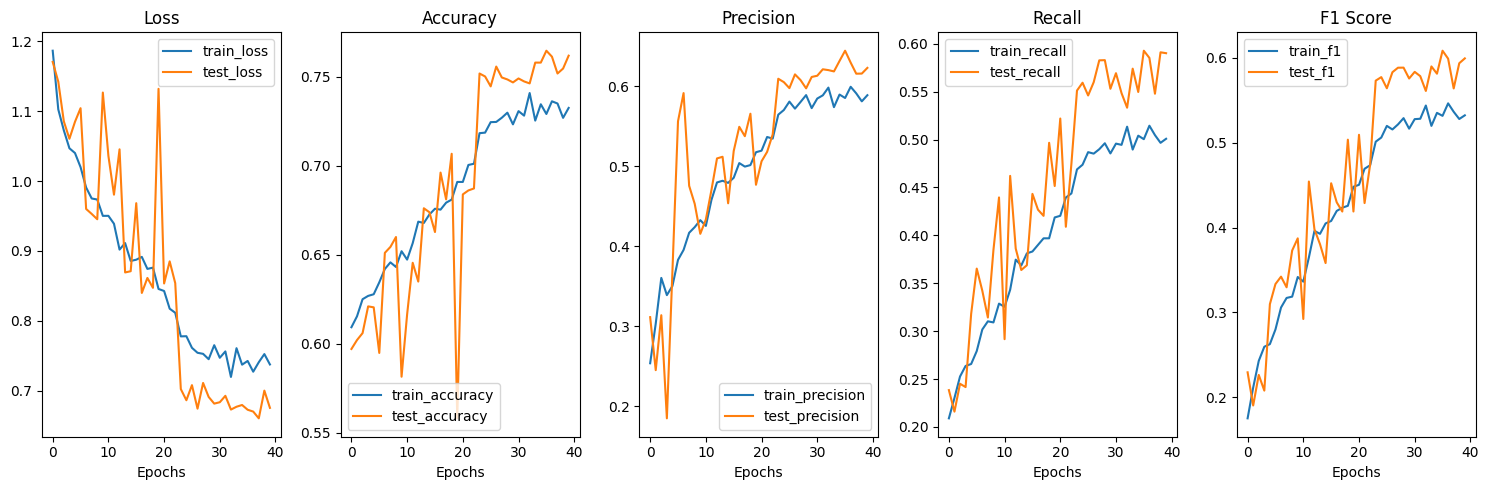

In [39]:
plot_loss_curves(results)

In [40]:
def calculate_average_results(results):
    # Calculate averages
    avg_train_loss = sum(results['train_loss']) / len(results['train_loss'])
    avg_test_loss = sum(results['test_loss']) / len(results['test_loss'])
    avg_train_precision = sum(results['train_precision']) / len(results['train_precision'])
    avg_test_precision = sum(results['test_precision']) / len(results['test_precision'])
    avg_train_recall = sum(results['train_recall']) / len(results['train_recall'])
    avg_test_recall = sum(results['test_recall']) / len(results['test_recall'])
    avg_train_f1 = sum(results['train_f1']) / len(results['train_f1'])
    avg_test_f1 = sum(results['test_f1']) / len(results['test_f1'])
    avg_train_accuracy = sum(results['train_acc']) / len(results['train_acc'])
    avg_test_accuracy = sum(results['test_acc']) / len(results['test_acc'])

    # Print average results
    print("Average Train Loss:", avg_train_loss)
    print("Average Test Loss:", avg_test_loss)
    print("Average Train Precision:", avg_train_precision)
    print("Average Test Precision:", avg_test_precision)
    print("Average Train Recall:", avg_train_recall)
    print("Average Test Recall:", avg_test_recall)
    print("Average Train F1 Score:", avg_train_f1)
    print("Average Test F1 Score:", avg_test_f1)
    print("Average Train Accuracy:", avg_train_accuracy)
    print("Average Test Accuracy:", avg_test_accuracy)

# Assuming 'results' is your dictionary containing the results
calculate_average_results(results)


Average Train Loss: 0.8638026303895145
Average Test Loss: 0.857985510749627
Average Train Precision: tensor(0.4996, device='cuda:0')
Average Test Precision: tensor(0.5244, device='cuda:0')
Average Train Recall: tensor(0.4058, device='cuda:0')
Average Test Recall: tensor(0.4559, device='cuda:0')
Average Train F1 Score: tensor(0.4266, device='cuda:0')
Average Test F1 Score: tensor(0.4588, device='cuda:0')
Average Train Accuracy: tensor(0.6879, device='cuda:0')
Average Test Accuracy: tensor(0.6899, device='cuda:0')


In [ ]:
"""
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

# cutout ve cutmix fonksiyonlarınızın buraya dahil edildiğini varsayıyoruz
# cutout, cutmix, rand_bbox fonksiyonlarını içe aktarın

def visualize_cutout_and_cutmix_from_dataloader(dataloader, device, length=16, alpha=1.0):
    # DataLoader'dan bir batch veri çek
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)

    # İlk görüntü üzerinde cutout ve cutmix işlemlerini uygula
    original_img = images[0].clone()
    cutout_img = cutout(images[0].unsqueeze(0).clone(), length=length).squeeze(0)
    cutmix_img, _ = cutmix(images[0].unsqueeze(0).clone(), images[1].unsqueeze(0).clone(), alpha=alpha)
    cutmix_img = cutmix_img.squeeze(0)

    # Görüntülerin Tensor formatından numpy formatına dönüştürülmesi
    original_img_np = original_img.permute(1, 2, 0).cpu().numpy()
    cutout_img_np = cutout_img.permute(1, 2, 0).cpu().numpy()
    cutmix_img_np = cutmix_img.permute(1, 2, 0).cpu().numpy()

    # Görselleştirme
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(original_img_np)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(cutout_img_np)
    axs[1].set_title("Cutout Image")
    axs[1].axis('off')

    axs[2].imshow(cutmix_img_np)
    axs[2].set_title("Cutmix Image")
    axs[2].axis('off')

    plt.show()

# Device belirle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Görselleştirme fonksiyonunu çağır
visualize_cutout_and_cutmix_from_dataloader(train_dataloader_custom, device)

"""